
































# Basic example using the MOGPTK

One fundamental pillar of MOGPTK are the data and model classes, where one stores the data for each channel and the other defines the model to use. In this tutorial we will show how to instanciate them and use them for a toy dataset.

This tutorial show examples for: __MOSM, CONV, CSM__ and __SM-LMC__ kernels


[Documentation](https://games-uchile.github.io/MultiOutputGP-Toolkit/)

In [1]:
# import library if it is not installed
import sys
sys.path.insert(0, '../')

import mogptk

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: remove when done:
%reload_ext autoreload
%autoreload 2

In [2]:
sns.set_style('ticks')
sns.set_context(context='notebook', font_scale=1.3)

## 1. Generate dataset

* Toy example with four sinusoidal signals.
* Same base frequency but different amplitude, phase and delay.

As a toy example we generate four sinusoidal signals. The four sinusses are each put in a channel and have the same frequency but differ in phase and delay. The observations are randomly picked in the range of [0,4], where the first channel will have the second half of the observations removed. The second channel will be a phased-delayed version, the third will have a second sinusoidal, and the fourth will have a time-delay.

In [3]:
# create data points

# time array
n_points = 100
t = np.linspace(0, 6, n_points)

# data for channel 1
y1 = np.sin(6 * t)
# add noise
y1 += np.random.normal(scale=0.1, size=len(t))

# phased version
y2 = np.sin(6 * t + 2)
y2 += np.random.normal(scale=0.1, size=len(t))

# added sinosoidal
y3 = np.sin(6 * t) - np.sin(4 * t)
y3 += np.random.normal(scale=0.1, size=len(t))

# delayed and amplified
y4 = 3 * np.sin(6 * (t - 2))
y4 += np.random.normal(scale=0.1, size=len(t))

Then for each time series (channels) we will create a data class object, and then we will create a list of data objects.

In [4]:
# data object for each channel
data1 = mogptk.Data(t, y1, name='A')

data2 = mogptk.Data(t, y2, name='B')

data3 = mogptk.Data(t, y3, name='C')

data4 = mogptk.Data(t, y4, name='D')

# create dataset
dataset = mogptk.DataSet(data1, data2, data3, data4)

Then we can remove the seconf half for the channel 'A' and randomly remove 40% for each channel

In [5]:
# remove randomly
for data in dataset:
    data.remove_randomly(pct=0.3)

# remove for channel 0
dataset[0].remove_range(start=2.0, end=None)

We can plot the signal in time and frequency domain

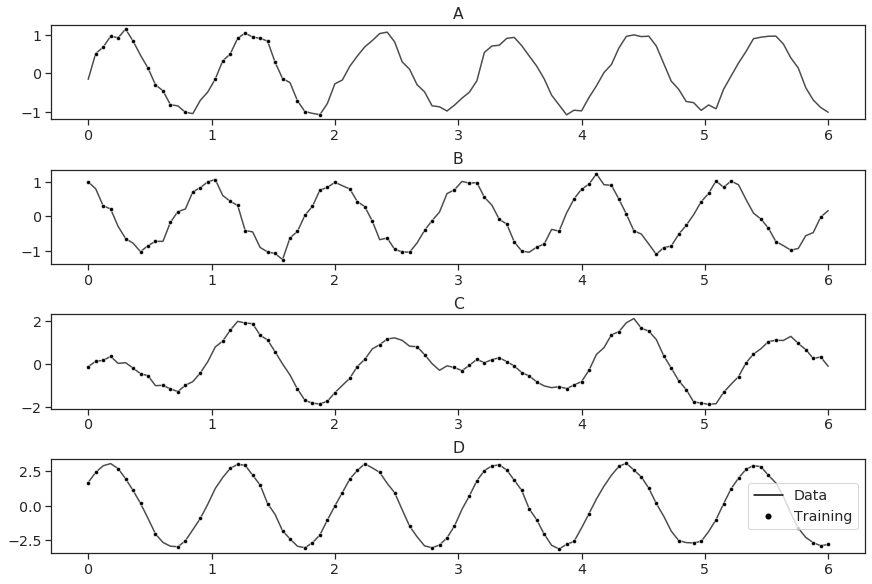

In [6]:
# plot data in time
_, _ = dataset.plot()

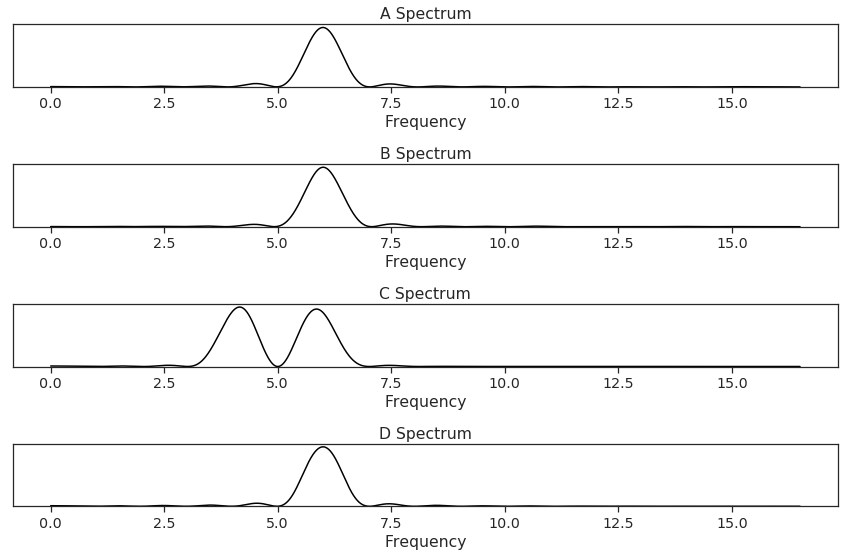

In [7]:
# plot spectrum
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(12, 8))

for i, data in enumerate(dataset):
    data.plot_spectrum(ax=axes[i])
plt.tight_layout()

With the data objects we can use any of the models of the toolkit

## 2. Models

To use a model we first create the object, then we can initialize the parameters and train/predict with ease

When we create the object, we have to pass the data list and the number of components. Initially the kernel parameters are at random, but we can __optionally__ re-initialize them to help the optimization by:

1. 'BNSE': Estimate the PSD for each channel via BNSE (bayesian non parametric spectral estimation, Tobar 2019), then utilize the position, magnitude and width of the **estimated spectrum peaks** as spectral means, weights and variance respectively.

2. 'SM': For each channel adjust a single output Gaussian process with spectral mixture kernel, and use said parameters as initial parameters for the kernel.

In [8]:
# create model
model = mogptk.MOSM(dataset, Q=2)
# model = mogptk.CSM(dataset, Q=2)
# model = mogptk.SMLMC(dataset, Q=2)
# model = mogptk.CG(dataset, Q=2)

# initialize parameters of kernel
model.estimate_params()

In [9]:
# we can plot the model parameters
model.print_params()

Likelihood,variance
,0.9999999999999999


With the model initialized we can obtain a preliminary prediction __before__ training

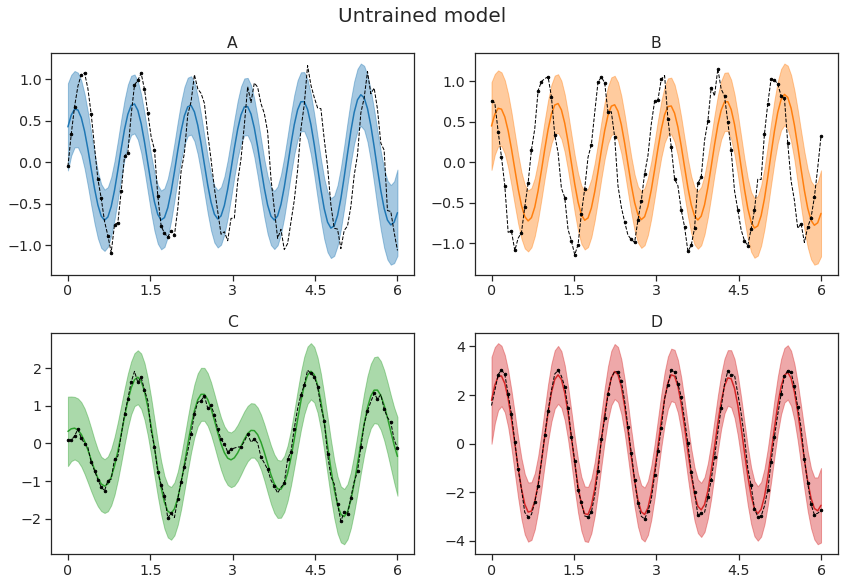

In [10]:
# plot the prediction with untrained model
x_pred = [t for i in range(len(dataset))]
model.predict(x_pred);

model.plot_prediction(title='Untrained model');

### 2.1 Training
The model can be trained using tensorflow of scipy optimizers

In [11]:
%%time
model.train(
    method='L-BFGS-B',
    tol=1e-60,
    maxiter=500)

CPU times: user 3min 40s, sys: 824 ms, total: 3min 41s
Wall time: 3min 35s


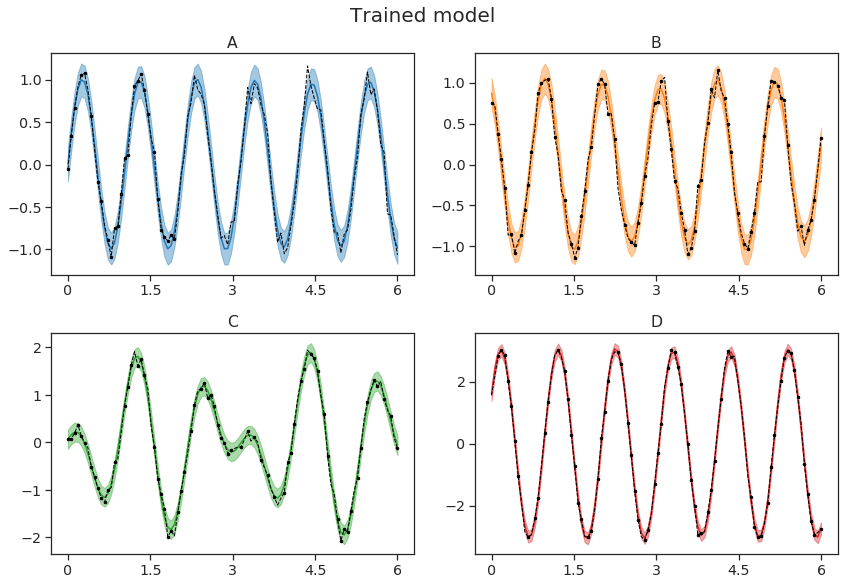

In [12]:
model.predict(x_pred);
model.plot_prediction(title='Trained model');

## 3. Prediction outside training range

Prediction can be made outside the training range easily using the `model.predict()` function.

For this we construct a list of ndarrays with the prediction inputs. The `model.predict()` returns the posterior mean, upper and lower confidence intervals. 

Upper and lower confidence intervals are used instead of the standar deviation of the posterior because the toolkit admits tranformations of the dataset (see section 4) and if the transformation is not linear -for example a log transformation- the process in the original domain will not be Gaussian.

In [13]:
# we use the same time for all the channels
input_pred = np.linspace(6, 10, 100)

x_pred = [input_pred for i in range(len(dataset))]

# mean, lower and higher confidence interval
y_pred, y_lo_ci, y_hi_ci = model.predict(x_pred)

The output of the function follows the same structure as the input, a list of length equal to the number of channels, where each element is a numpy array with the predictions on said channel.

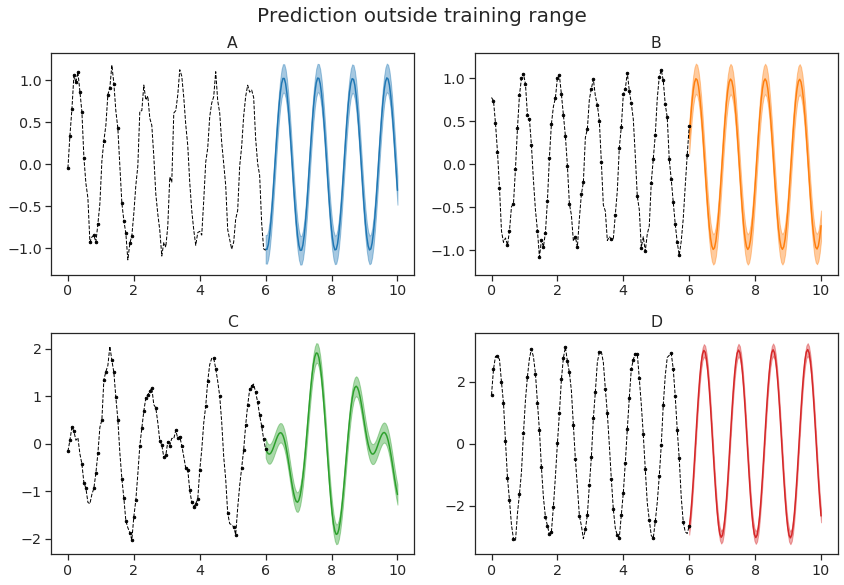

In [14]:
fig, axarr = model.plot_prediction(title='Prediction outside training range');

## 4. Transformations on data

Currently the toolkit admits the following transformation on channels:

* Normalization.
* Polinomial detrending.
* Logarithmical.

These can be applied in succesion, the toolkit keeps tracks of them to apply the inverse tranformation on the process when doing predictions.


New transformations can be easily done, implementing the forward and backwards methods for each one (the transformations has to be invertible)

As en example, lets take the exponential of the original data, for the first 3 channels, and fit the model with log transformation for those channels.

In [15]:
dataset2 = mogptk.DataSet()

dataset2.append(mogptk.Data(t, np.exp(y1), name='1'))
dataset2.append(mogptk.Data(t, np.exp(y2), name='2'))
dataset2.append(mogptk.Data(t, np.exp(y3), name='3'))
dataset2.append(mogptk.Data(t, y4, name='4'))

for data in dataset2:
    data.remove_randomly(pct=0.3)

dataset2[0].remove_range(start=2.0, end=None)

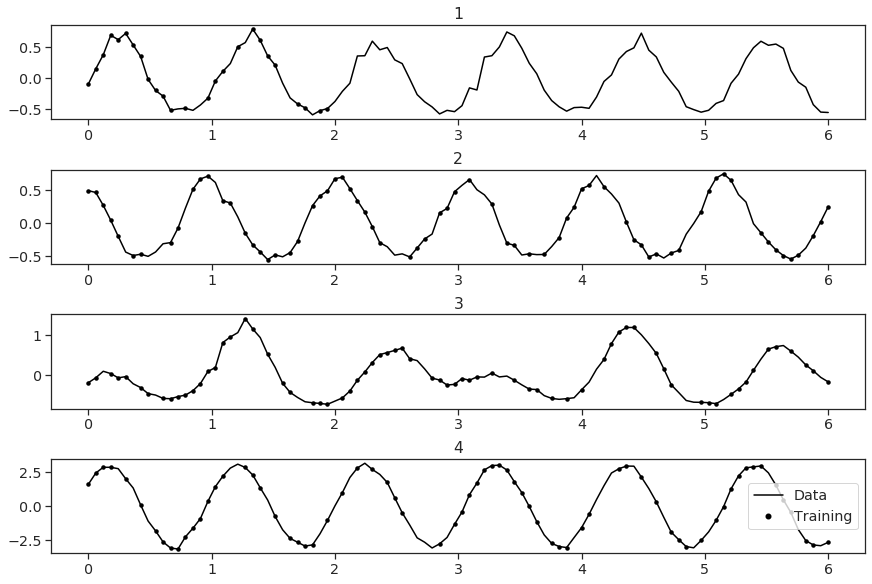

In [16]:
# apply transformations
for data in dataset2[:-1]:
    data.transform(mogptk.TransformLog)
dataset2.plot();

In [17]:
model2 = mogptk.MOSM(dataset2, Q=2)
model2.estimate_params('BNSE')
model2.train()

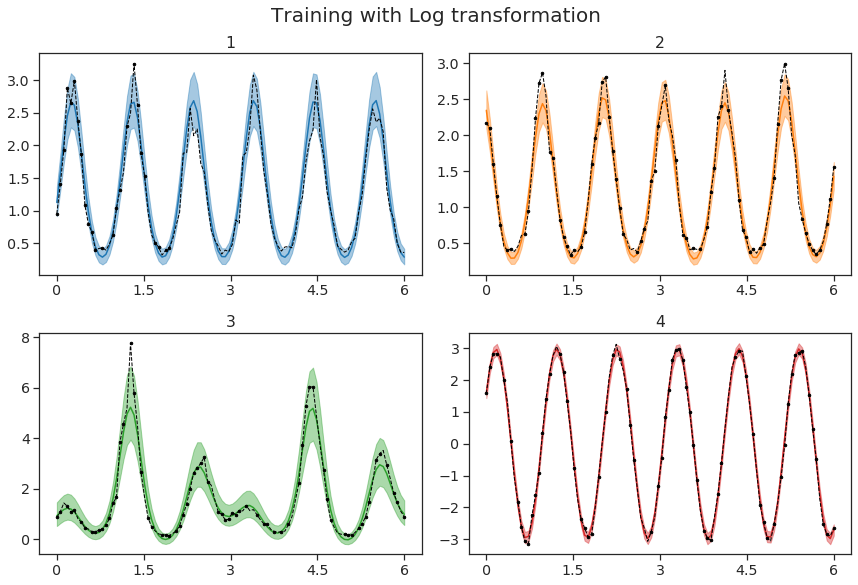

In [18]:
x_pred = [t for i in range(len(dataset2))]
model2.predict(x_pred);
model2.plot_prediction(title='Training with Log transformation');

## 5. Load CSV

The toolkit also allows to load datasets directly to the model from a csv file with `mogptk.LoadCSV()`, where we specify the file, and the name of the columns for input and output and it returns a Data class object.

As an example, let's load the price of Oil and gold.

In [19]:
oil = mogptk.LoadCSV(filename='data/gonu/brent-daily.csv',
                     x_cols='Date',
                     y_cols='Price',
                     names='Oil',
                     format={'Date': mogptk.FormatDate},
                    )
gold = mogptk.LoadCSV(filename='data/gonu/lmba-gold-usd-am-daily.csv',
                      x_cols='Date',
                      y_cols='Price',
                      names='Gold',
                      format={'Date': mogptk.FormatDate},
                      na_values='.',
                     )

dataset3 = mogptk.DataSet(oil, gold)

Once the data is loaded, the toolkit have a series of tools to:_ filter, agregate by days, remove ranges and set prediction ranges_ by specifying the date range rather than the internal values used as inputs.

(<Figure size 864x576 with 2 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f797c0581d0>],
       dtype=object))

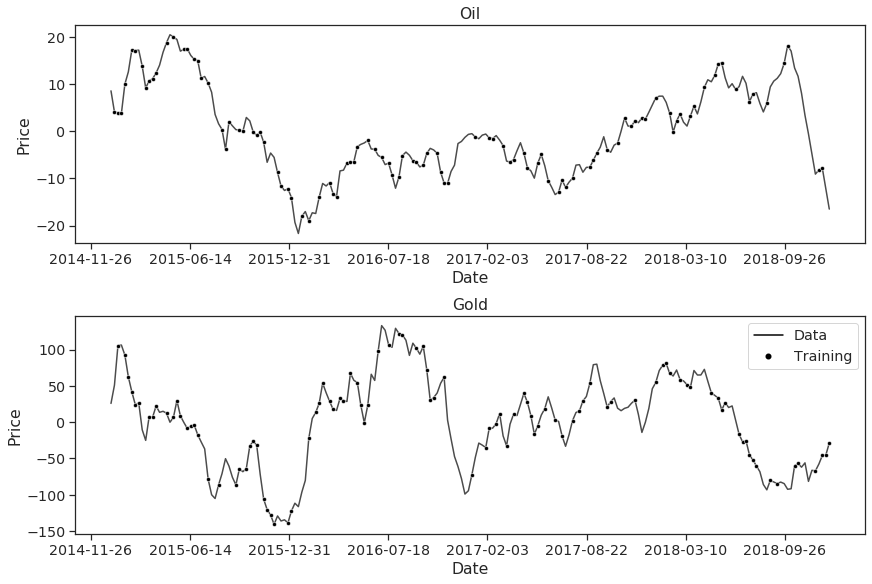

In [20]:
for channel in dataset3:
    # filter by date
    channel.filter('2015-01-01', '2018-12-31')
    # agregate from daily to weekly
    channel.aggregate('7d')
    
    # channel.transform(mogptk.TransformLog)
    channel.transform(mogptk.TransformDetrend(1))
    
    # remove by date range
    channel.remove_range('2016-11-15', '2017-01-01')
    channel.remove_randomly(pct=0.5)
    
    # set prediction range by date
    channel.set_pred_range('2015-01-01', '2018-12-31', step='1d')
    
dataset3.plot()

With this we can train the model normaly and set a prediction range by date

In [21]:
model3 = mogptk.MOSM(dataset3, Q=3)

model3.estimate_params('BNSE')

model3.train(method='L-BFGS-B', maxiter=2000, tol=1e-50)

We can set the prediction range by dates and then predict, in this case we call the predict function without arguments as the range where already set

In [22]:
for i in range(len(dataset3)):    
    model3.dataset[i].set_pred_range('2015-01-01', '2019-05-01', step='1d')

x_pred = [data.X_pred for data in model3.dataset]

y_pred, low_ci, hi_ci = model3.predict(x_pred)

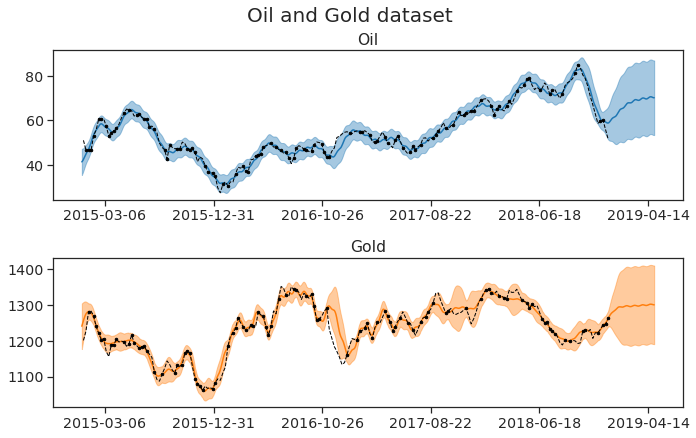

In [23]:
# base figure
fig, axarr = model3.plot_prediction(grid=(2, 1), figsize=(10, 6), title='Oil and Gold dataset')

## 6. Load/Save Models

Models can be easily saved for posterior use.

In [24]:
# save the first model
model3.save_params('mosm_toy_example')

In [25]:
# load mode
new_model = mogptk.MOSM(dataset3, Q=3)
params = new_model.load_params('mosm_toy_example')

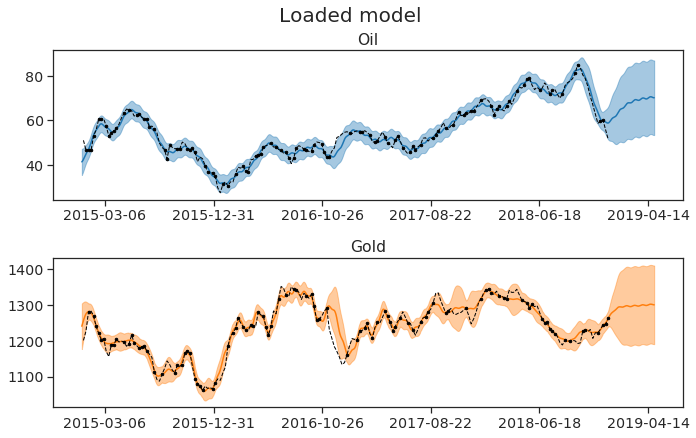

In [26]:
new_model.plot_prediction(grid=(2, 1), figsize=(10, 6), title='Loaded model');